In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

import tensorflow as tf

Using TensorFlow backend.


In [2]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [3]:
from PIL import Image
import os
from pylab import *
import re
from PIL import Image, ImageChops, ImageEnhance

In [4]:
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path)]

In [5]:
def convert_to_ela_image(path, quality):
    filename = path
    resaved_filename = filename.split('.')[0] + '.resaved.jpg'
    ELA_filename = filename.split('.')[0] + '.ela.png'
    
    im = Image.open(filename).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality=quality)
    resaved_im = Image.open(resaved_filename)
    
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    
    return ela_im

In [6]:
fakes_datasets_filename = get_imlist('datasets/train/fake/')
reals_datasets_filename = get_imlist('datasets/train/real/')

# Starts Here

In [7]:
fake_imfile_list = []
for filename in fakes_datasets_filename[0:3000]:
    fake_imfile_list.append(array(convert_to_ela_image(filename, 90).resize((128, 128))).flatten())

In [8]:
real_imfile_list = []
for filename in reals_datasets_filename[0:3000]:
    real_imfile_list.append(array(convert_to_ela_image(filename, 90).resize((128, 128))).flatten())

In [9]:
len(fake_imfile_list)

3000

In [10]:
len(real_imfile_list)

3000

# Lanjut

In [11]:
for index, fake_imfile in enumerate(fake_imfile_list):
    fake_imfile_list[index] = array(fake_imfile) / 255.0

In [12]:
for index, real_imfile in enumerate(real_imfile_list):
    real_imfile_list[index] = array(real_imfile) / 255.0

# Change to Data Frame

## Extend and Delete

In [13]:
X = []
X.extend(fake_imfile_list)
X.extend(real_imfile_list)

In [14]:
len(X)

6000

In [15]:
X = np.array(X)
X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.03529412, 0.01568627,
        0.03529412],
       ...,
       [0.        , 0.05490196, 0.10980392, ..., 0.05490196, 0.05490196,
        0.05490196],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## Add Y

In [16]:
Y = []
for i in range(len(fake_imfile_list)):
    Y.append(1)
for i in range(len(real_imfile_list)):
    Y.append(0)

In [17]:
Y = to_categorical(Y, num_classes=2)

In [18]:
Y.shape

(6000, 2)

# Reshape X

In [19]:
X = X.reshape(-1, 128, 128, 3)

In [20]:
X.shape

(6000, 128, 128, 3)

## Train Test Split

In [21]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.1, random_state=5)

# Model

In [22]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu', input_shape = (128,128,3)))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu'))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'valid', 
                 activation ='relu'))

model.add(MaxPool2D(pool_size=(2,2), strides=2))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

In [23]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)


In [24]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


In [25]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


In [26]:
epochs = 20
batch_size = 100

In [27]:
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_val, Y_val), verbose = 2, callbacks=[learning_rate_reduction])

Train on 5400 samples, validate on 600 samples
Epoch 1/20
 - 11s - loss: 0.7355 - acc: 0.5770 - val_loss: 0.5917 - val_acc: 0.7233
Epoch 2/20
 - 9s - loss: 0.6206 - acc: 0.6809 - val_loss: 0.5575 - val_acc: 0.7533
Epoch 3/20
 - 9s - loss: 0.5482 - acc: 0.7404 - val_loss: 0.6679 - val_acc: 0.6417
Epoch 4/20
 - 10s - loss: 0.5213 - acc: 0.7602 - val_loss: 0.5299 - val_acc: 0.7500
Epoch 5/20
 - 9s - loss: 0.5199 - acc: 0.7709 - val_loss: 0.5705 - val_acc: 0.7283

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/20
 - 9s - loss: 0.4521 - acc: 0.8081 - val_loss: 0.5815 - val_acc: 0.7317
Epoch 7/20
 - 10s - loss: 0.4321 - acc: 0.8209 - val_loss: 0.5807 - val_acc: 0.7367
Epoch 8/20
 - 10s - loss: 0.4093 - acc: 0.8352 - val_loss: 0.6079 - val_acc: 0.7317

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 9/20
 - 10s - loss: 0.3706 - acc: 0.8498 - val_loss: 0.6072 - val_acc: 0.7450
Epoch 10/20
 - 10s - loss: 0.3596 - acc

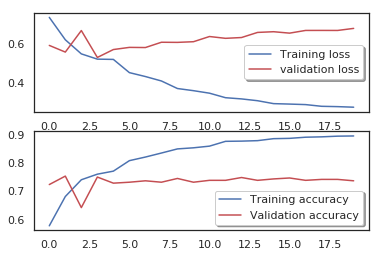

In [28]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

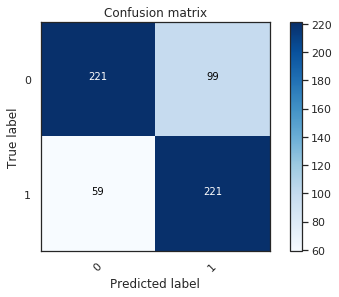

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))